# **PACKAGES**

In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

ROOT_DIR = os.getcwd()
if not ROOT_DIR.endswith('sendy_scripts'):
    ROOT_DIR = os.path.dirname(ROOT_DIR)
    
os.chdir(ROOT_DIR)

import xgboost as xgb
from src.processors import Preprocessor
from src.models import XGB_Model

.

# **DATA LOADING**

In [38]:
train = pd.read_csv("../data/Train.csv")
test = pd.read_csv("../data/Test.csv")
riders = pd.read_csv("../data/Riders.csv")

.

# **DATA PREPROCESSING**

In [39]:
train, target = Preprocessor().separate(train)

In [40]:
train = Preprocessor().preprocess_data(train, True)
test = Preprocessor().preprocess_data(test, False)

.

# **MODELIZATION**

## **XGBOOST**

In [16]:
dtrain = xgb.DMatrix(train.drop("Order No", axis=1), label=target)

/usr/local/anaconda3/envs/Sendy/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/anaconda3/envs/Sendy/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [17]:
params = {
    'max_depth': 4, 
    'eta': 0.1, 
    'objective': 'reg:squarederror',
    'nthread'  : 4,
    'eval_metric' : "rmse",
    #'num_round' : 10
}

In [18]:
bst = xgb.train(params, dtrain)

In [54]:
cv_rmse_xgb = xgb.cv(params, dtrain, num_boost_round=1000, nfold=10, stratified=False, folds=None, metrics="rmse", seed=0)

In [55]:
cv_rmse_xgb

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,1694.911157,1.937340,1694.913489,18.469025
1,1564.542993,1.900884,1564.724121,18.713276
2,1450.296326,1.879179,1450.629077,19.126043
3,1350.581287,1.859077,1351.071802,19.601216
4,1263.917578,1.865795,1264.758936,20.108320
...,...,...,...,...
995,567.894037,3.650019,766.653607,20.781112
996,567.725769,3.658387,766.649390,20.740776
997,567.582635,3.655573,766.701849,20.745349
998,567.430969,3.648553,766.735608,20.741426


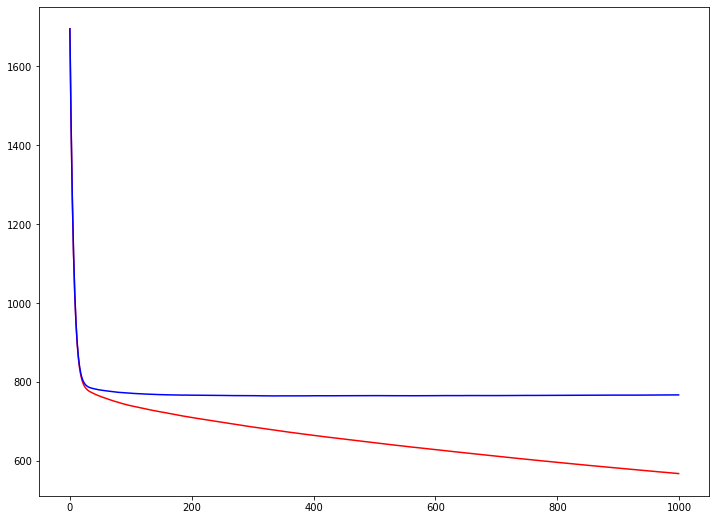

In [56]:
plt.figure(figsize=(12,9))

plt.plot(cv_rmse_xgb['train-rmse-mean'], color="red")
#plt.plot(cv_rmse_xgb['train-rmse-mean'] + cv_rmse_xgb['train-rmse-std'], color="red", marker="+")
#plt.plot(cv_rmse_xgb['train-rmse-mean'] - cv_rmse_xgb['train-rmse-std'], color="red", marker="+")
plt.plot(cv_rmse_xgb['test-rmse-mean'], color="blue")
#plt.plot(cv_rmse_xgb['test-rmse-mean'] + cv_rmse_xgb['test-rmse-std'], color="blue", marker="+")
#plt.plot(cv_rmse_xgb['test-rmse-mean'] - cv_rmse_xgb['test-rmse-std'], color="blue", marker="+")

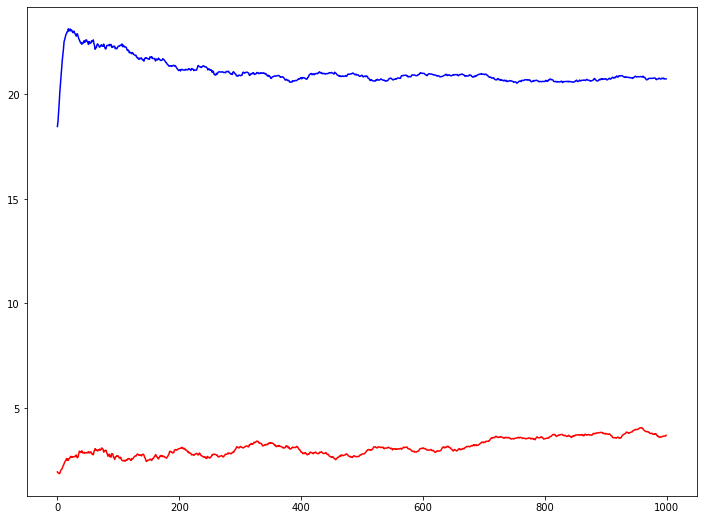

In [57]:
plt.figure(figsize=(12,9))

plt.plot(cv_rmse_xgb['train-rmse-std'], color="red")
plt.plot(cv_rmse_xgb['test-rmse-std'], color="blue")